<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Working/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [1]:
# #-----refesh python script-------#
# get_ipython().kernel.do_shutdown(restart=True)

# #----GPU Setup------#
# #Check GPUs
# !nvidia-smi

# #load cudf to use GPUs for analysis
# %load_ext cudf.pandas


#------Imports--------#
import pandas as pd
import datetime
import pickle
import numpy as np
import requests
import time
import os


#-------Froms-------#
from tqdm.notebook import tqdm
from datetime import datetime, timedelta


# #------Force Connect MyDrive-------#
# from google.colab import drive
# drive.mount('/content/drive')


# Stock Data

## Ensure the last 6 months of EODHD Data is available

In [2]:
# Ensure the last 6 months of EODHD Data is available
"""
Returns:
nasdaq_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 627225 entries, 0 to 627224
  Data columns (total 8 columns):
  #   Column          Non-Null Count   Dtype
  ---  ------          --------------   -----
  0   date            627225 non-null  datetime64[ns]
  1   ticker          627098 non-null  object
  2   open            627225 non-null  float64
  3   high            627225 non-null  float64
  4   low             627225 non-null  float64
  5   close           627225 non-null  float64
  6   adjusted_close  627225 non-null  float64
  7   volume          627225 non-null  float64
"""
#API_KEY = 'demo'  # Replace with your API key if not using demo
API_KEY = '68433aff09ea73.10710364'
EXCHANGE = 'NASDAQ'
DAYS_BACK = 180  # Approx. 6 months
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv'
MAX_CALLS_PER_RUN = 200  # Use 1–5 for the free tier
SECONDS_BETWEEN_CALLS = 0  # Add delay to be respectful

# Generate past 6 months of weekdays
today = datetime.utcnow().date()
dates = [today - timedelta(days=i) for i in range(DAYS_BACK)]
dates = sorted([d for d in dates if d.weekday() < 5])  # Keep only weekdays

# Load already-downloaded dates if file exists
downloaded_dates = set()
if os.path.exists(SAVE_PATH):
    df_existing = pd.read_csv(SAVE_PATH)
    downloaded_dates = set(pd.to_datetime(df_existing['date']).dt.date)
# Filter to only dates we haven’t downloaded
pending_dates = [d for d in dates if d not in downloaded_dates]

# Prepare data holder
all_data = []

for i, date in enumerate(pending_dates[:MAX_CALLS_PER_RUN]):
    date_str = date.strftime('%Y-%m-%d')
    url = f'https://eodhd.com/api/eod-bulk-last-day/{EXCHANGE}?api_token={API_KEY}&fmt=json&date={date_str}'
    print(f"[{i+1}] Fetching {date_str}...")

    try:
        response = requests.get(url)
        response.raise_for_status()
        day_data = response.json()

        for entry in day_data:
            all_data.append({
                'date': entry.get('date'),
                'ticker': entry.get('code'),
                'open': entry.get('open'),
                'high': entry.get('high'),
                'low': entry.get('low'),
                'close': entry.get('close'),
                'adjusted_close': entry.get('adjusted_close'),
                'volume': entry.get('volume'),
            })

        # Respect the delay
        if i < MAX_CALLS_PER_RUN - 1:
            time.sleep(SECONDS_BETWEEN_CALLS)

    except Exception as e:
        print(f"⚠️ Error on {date_str}: {e}")

# Append or save the new data
if all_data:
    df_new = pd.DataFrame(all_data)
    if os.path.exists(SAVE_PATH):
        df_existing = pd.read_csv(SAVE_PATH)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(SAVE_PATH, index=False)
    print(f"✅ Data for {len(all_data)} entries added to {SAVE_PATH}")
else:
    print("⚠️ No new data fetched.")

# Import CSV into code
nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")

[1] Fetching 2025-06-12...
[2] Fetching 2025-06-13...
✅ Data for 5013 entries added to /content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv


## Get list of Tickers with Min Market Cap and populate screener_data_df

In [24]:
# Get list of Tickers with a min market cap and a list of common stocks
"""
Returns:
screener_data_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 262 entries, 0 to 261
  Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
  ---  ------                 --------------  -----
 0   code                   262 non-null    object
 1   name                   262 non-null    object
 2   last_day_data_date     262 non-null    object
 3   adjusted_close         262 non-null    float64
 4   refund_1d              262 non-null    float64
 5   refund_1d_p            262 non-null    float64
 6   refund_5d              262 non-null    float64
 7   refund_5d_p            262 non-null    float64
 8   exchange               262 non-null    object
 9   currency_symbol        262 non-null    object
 10  market_capitalization  262 non-null    int64
 11  earnings_share         262 non-null    float64
 12  dividend_yield         145 non-null    float64
 13  sector                 262 non-null    object
 14  industry               262 non-null    object
 15  avgvol_1d              262 non-null    int64
 16  avgvol_200d            262 non-null    float64
 17  Country                262 non-null    object
 18  Exchange               262 non-null    object
 19  Currency               262 non-null    object
 20  Type                   262 non-null    object
 21  last_day_change        262 non-null    float64

"""

# -------------------- CONFIG --------------------
API_KEY = '68433aff09ea73.10710364'  # Replace with your EODHD key
MIN_MARKET_CAP = 10_000_000_000  # Changeable: $1B, $10B, etc.
EXCHANGE = 'NASDAQ'
RESULTS_PER_PAGE = 500  # Max per EODHD API
# ------------------------------------------------

def get_filtered_nasdaq_stocks(api_key, min_cap, exchange="NASDAQ"):
    all_data = []
    offset = 0

    while True:
        url = (
            "https://eodhd.com/api/screener"
            f"?api_token={api_key}"
            f"&filters=["
            f'["exchange","=","{exchange}"],'
            #f'["type","=","Common Stock"],'
            f'["market_capitalization",">=",{min_cap}]'
            f"]"
            f"&sort=market_capitalization.desc"
            f"&limit={RESULTS_PER_PAGE}&offset={offset}&fmt=json"
        )

        response = requests.get(url)
        result = response.json()
        batch = result.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        offset += RESULTS_PER_PAGE

    return pd.DataFrame(all_data)

# Run filter to get screener_data_df
screener_data_df = get_filtered_nasdaq_stocks(API_KEY, MIN_MARKET_CAP)

# Get exchange symbol list with type
meta_url = f'https://eodhd.com/api/exchange-symbol-list/NASDAQ?api_token={API_KEY}&fmt=json'
meta_df = pd.DataFrame(requests.get(meta_url).json())
common_df = meta_df[meta_df['Type'] == 'Common Stock'].copy() # Add .copy() to avoid SettingWithCopyWarning

# Combine screener_data_df with relevant columns from common_df
screener_data_df = pd.merge(
    screener_data_df,
    common_df[['Code', 'Country', 'Exchange', 'Currency', 'Type']],
    left_on='code',
    right_on='Code',
    how='inner'
).drop('Code', axis=1)

# --- Calculate Daily Change ---

if 'nasdaq_df' in locals() and not nasdaq_df.empty:
    # Ensure date is datetime
    nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

    # Sort and calculate daily change on the original nasdaq_df
    temp_nasdaq_sorted = nasdaq_df.sort_values(by=['ticker', 'date']).copy()
    temp_nasdaq_sorted['daily_change'] = temp_nasdaq_sorted.groupby('ticker')['adjusted_close'].pct_change()

    # Get the last day's data from the temp sorted dataframe
    last_date = temp_nasdaq_sorted['date'].max()
    last_day_data = temp_nasdaq_sorted[temp_nasdaq_sorted['date'] == last_date]
    last_day_changes = last_day_data.set_index('ticker')['daily_change'].to_dict()

    # Append last_day_changes to screener_data_df
    screener_data_df['last_day_change'] = screener_data_df['code'].map(last_day_changes)
    # Fill potential NaN values if some tickers in screener_data_df didn't have data on the last day
    screener_data_df['last_day_change'] = screener_data_df['last_day_change'].fillna(0)
else:
    print("Warning: nasdaq_df not found or empty. Cannot calculate and append last_day_change.")

## Filter nasdaq data for screener_data_df and type: common

In [26]:
# prompt: I want to filter the Nasdaq stocks to only include tickers that are part of the common_df and the min_market_cap_df. Same this df as a new variable
# Load your EOD data
from datetime import datetime, timedelta
# nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

# Now filter nasdaq_df using the combined dataframe and type 'Common Stock'
filtered_nasdaq_df = nasdaq_df[
    nasdaq_df['ticker'].isin(screener_data_df[screener_data_df['Type'] == 'Common Stock']['code'])
]

## Function: Correlation Coeficient for entire stock data set

In [27]:
#return six month and three month spearman correlations for all unique pairs of stocks

import pandas as pd
from datetime import datetime # Import datetime
from tqdm.notebook import tqdm # Import tqdm

# ## Function: Correlation Coeficient for entire stock data set
def calculate_lagged_correlation(df, lag_days, range_months):
  """
  Calculates the pairwise spearman correlation coefficient between all stocks
  in a DataFrame for a specified period with a given lag.
  The start date is calculated by subtracting range_months from today's date.

  Args:
    df: DataFrame with 'date', 'ticker', and 'adjusted_close' columns.
    lag_days: The number of days to lag the second stock's data.
    range_months: The number of months to include in the analysis period.

  Returns:
    correlation_matrix: A pandas DataFrame with the following
      Index: Tickers
      Columns: Tickers
      Values: Spearman correlation coefficients between stocks
  """
  # Calculate the end date (today's date)
  end_datetime = datetime.now()

  # Calculate the start date for the specified period by subtracting range_months
  start_datetime = end_datetime - pd.DateOffset(months = range_months)


  # Ensure the 'date' column is in datetime format
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for the specified date range
  filtered_df = df[(df['date'] >= start_datetime) & (df['date'] <= end_datetime)].copy()

  # Filter out rows where volume is 0
  filtered_df = filtered_df[filtered_df['volume'] > 0].copy()

  # Get unique tickers in the filtered data
  tickers = filtered_df['ticker'].unique()

  #breakpoint()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker and name the series for clarity
    stock_a_data = filtered_df[filtered_df['ticker'] == ticker_a].set_index('date')['adjusted_close']
    #breakpoint()

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker and name the series for clarity
        stock_b_data = filtered_df[filtered_df['ticker'] == ticker_b].set_index('date')['adjusted_close']
        #breakpoint()

        # Align the dataframes based on the date index
        # Suffixes will be applied to the 'adjusted_close' column name
        aligned_data = pd.merge(stock_a_data, stock_b_data,
                                left_index=True, right_index=True,
                                how='inner', suffixes=('_A', '_B'))

        # Apply the lag to stock_b_data, referencing the suffixed column name
        lagged_stock_b_data = aligned_data['adjusted_close_B'].shift(lag_days)

        #breakpoint()

        # Calculate correlation, dropping NaN values
        # Using Spearman method and minimum periods
        #correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman')


        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix


In [28]:
# prompt: Can you check my Google drive for three_month_spearman_lagged_correlations and
# six_month_spearman_lagged_correlations first and pull in those CSVs if found. If not, run
# the calculate_lagged_correlation function and save these csvs as Today’s
# date_six_month_spearman_lagged_correlation and today’s date_three_month_spearman_lagged_correlation
"""
Returns:
  three_month_spearman_lagged_correlations and six_month_spearman_lagged_correlations: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: Spearman correlation coefficients between stocks
"""
import pandas as pd
import os
from datetime import datetime

# Define the file paths in Google Drive
today_str = datetime.now().strftime('%Y%m%d')
three_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_three_month_spearman_lagged_correlation.csv'
six_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_six_month_spearman_lagged_correlation.csv'

# Check if files exist and load them
try:
    three_month_spearman_lagged_correlations = pd.read_csv(three_month_file, index_col=0)
    print(f"Loaded existing file: {three_month_file}")
    six_month_spearman_lagged_correlations = pd.read_csv(six_month_file, index_col=0)
    print(f"Loaded existing file: {six_month_file}")

except FileNotFoundError:
    print("One or both correlation files not found. Calculating correlations...")
    # Calculate correlations if files don't exist
    # Ensure 'filtered_nasdaq_df' is defined from the preceding code
    if 'filtered_nasdaq_df' in locals():
        three_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=3)
        six_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=6)

        # Save the newly calculated correlations to Google Drive
        three_month_spearman_lagged_correlations.to_csv(three_month_file)
        print(f"Saved calculated file: {three_month_file}")
        six_month_spearman_lagged_correlations.to_csv(six_month_file)
        print(f"Saved calculated file: {six_month_file}")
    else:
        print("Error: 'filtered_nasdaq_df' is not defined. Please ensure the preceding code ran correctly.")

One or both correlation files not found. Calculating correlations...


<ipython-input-27-784628608>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Calculating correlations:   0%|          | 0/262 [00:00<?, ?it/s]

<ipython-input-27-784628608>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Calculating correlations:   0%|          | 0/262 [00:00<?, ?it/s]

Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250613_three_month_spearman_lagged_correlation.csv
Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250613_six_month_spearman_lagged_correlation.csv


## Unified_Correlation

In [29]:
# prompt: Unified_Collelation
# use the six month correlation except if 3 month correlation is smaller.
# negative correlations are not used so this is not a concern
"""
Returns:
  unified_correlation_df: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: unified_correlation

"""

# A more concise way to implement the logic:
unified_correlation_df = three_month_spearman_lagged_correlations.where(
    (three_month_spearman_lagged_correlations > 0) & (six_month_spearman_lagged_correlations > 0)
).apply(
    lambda row: np.minimum(row, six_month_spearman_lagged_correlations.loc[row.name]),
    axis=1
).fillna(0)

## Process correlated Data and get prediction score

In [130]:
# Function to process stock correlation data, calculate prediction scores,
# and filter connections for visualization based on the prediction score.
def process_and_score_stocks(
    correlation_df,
    six_month_correlations,
    three_month_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent,
    market_cap_offset=1e9,  # Make offset configurable
    min_planet_size=0.05,   # Make planet size bounds configurable
    max_planet_size=1.5
):
    """
    Processes stock correlation data for a specific source ticker.
    It filters for positive correlations, computes raw and normalized prediction scores,
    filters connections based on the normalized prediction score to limit displayed nodes,
    and then calculates visualization parameters (orbital/planet radius) for the filtered set.

    Args:
      correlation_df: DataFrame with unified correlation coefficients (tickers as index/columns).
      six_month_correlations: The six-month spearman lagged correlation matrix.
      three_month_spearman_lagged_correlations: The three-month spearman lagged correlation matrix.
      screener_data_df: DataFrame with additional information about stocks.
      source_ticker: The ticker symbol for which to process data and calculate the score.
      min_nodes: The minimum number of correlated stocks to return for the source ticker.
      max_nodes: The maximum number of correlated stocks to return for the source ticker.
      threshold_percent: A percentage (0.0 to 1.0) of the maximum absolute normalized
                         prediction score to use as a filtering threshold.
      market_cap_offset: An offset added to market cap before taking log for weight calculation
                         to handle small values and smooth scaling (default 1e9).
      min_planet_size: The minimum radius for a planet node in the visualization (default 0.05).
      max_planet_size: The maximum radius for a planet node in the visualization (default 1.5).


    Returns:
      processed_data_df: A pandas DataFrame containing processed data for the source ticker
                         and its filtered correlated stocks, including all necessary columns
                         for visualization and explanation. Returns an empty DataFrame
                         if no connections are found after filtering.
      prediction_score: The overall calculated prediction score for the source ticker
                         based on the *filtered* connections (sum of their normalized weights).
                         Returns 0 if no connections are found.
    """
    # --- Data Unpivoting and Initial Setup ---
    # Reset index to make source a column and stack to unpivot the correlation matrix.
    correlation_df = correlation_df.rename_axis('source', axis=0)
    grouped_correlation_data = correlation_df.stack().reset_index()
    # Rename columns for clarity: source ticker, target ticker, and their unified correlation.
    grouped_correlation_data.columns = ['source', 'target', 'unified_correlation']

    # Remove self-correlations (correlation of a stock with itself) AND connections where the source is the target.
    grouped_correlation_data = grouped_correlation_data[
        (grouped_correlation_data['source'] != grouped_correlation_data['target']) &
        (grouped_correlation_data['target'] != source_ticker)
    ].copy()

    # Calculate the Coefficient of Determination (R-squared), which is the square of the correlation.
    # It represents the proportion of the variance in one variable that is predictable from the other.
    grouped_correlation_data['coefficient_of_determination'] = grouped_correlation_data['unified_correlation']**2

    # --- Filter for the specific source ticker and positive correlations ---
    # Select only the connections where the source ticker is the source ticker.
    source_connections = grouped_correlation_data[grouped_correlation_data['source'] == source_ticker].copy()

    # If the source ticker has no connections in the data, return empty results immediately.
    if source_connections.empty:
        print(f"No correlation data found for source ticker {source_ticker}.")
        # Return a DataFrame with expected columns but no data, and a score of 0.
        empty_cols = [
            'source', 'target', 'unified_correlation', 'coefficient_of_determination',
            'six_month_spearman_correlation', 'three_month_spearman_correlation',
            'Orbital Radius', 'Market Cap', 'Planet Radius',
            'prediction_score', 'normalized_prediction_score'
        ]
        return pd.DataFrame(columns=empty_cols), 0.0

    # Filter for only positive unified correlations, as negative correlations are not used in this model's weighting.
    positive_corr_group = source_connections[source_connections['unified_correlation'] > 0].copy()

    # If no positive correlations are found, return empty results.
    if positive_corr_group.empty:
        print(f"No positive correlations found for source ticker {source_ticker}.")
        empty_cols = [
            'source', 'target', 'unified_correlation', 'coefficient_of_determination',
            'six_month_spearman_correlation', 'three_month_spearman_correlation',
            'Orbital Radius', 'Market Cap', 'Planet Radius',
            'prediction_score', 'normalized_prediction_score'
        ]
        return pd.DataFrame(columns=empty_cols), 0.0

    # --- Add Six and Three Month Correlations (before filtering based on score) ---
    # Merge six_month_correlations to get the 6-month spearman coefficient for each positive connection.
    positive_corr_group['six_month_spearman_correlation'] = positive_corr_group.apply(
        lambda row: six_month_correlations.loc[row['source'], row['target']] if row['source'] in six_month_correlations.index and row['target'] in six_month_correlations.columns else 0, axis=1
    )
    # Merge three_month_correlations to get the 3-month spearman coefficient.
    positive_corr_group['three_month_spearman_correlation'] = positive_corr_group.apply(
        lambda row: three_month_correlations.loc[row['source'], row['target']] if row['source'] in three_month_correlations.index and row['target'] in three_month_correlations.columns else 0, axis=1
    )

    # --- Add additional info from screener_data_df (before filtering) ---
    # Select relevant columns from screener_data_df, excluding the ones to be removed later.
    screener_cols_to_add = ['code', 'market_capitalization', 'last_day_change']

    # Validate that required columns exist in screener_data_df before proceeding
    required_screener_cols = ['code', 'market_capitalization', 'last_day_change']
    if not all(col in screener_data_df.columns for col in required_screener_cols):
        missing = [col for col in required_screener_cols if col not in screener_data_df.columns]
        raise ValueError(f"screener_data_df is missing required columns: {missing}")


    screener_info = screener_data_df[screener_cols_to_add].copy()
    # Rename 'code' to 'target' to facilitate merging with the correlations DataFrame.
    screener_info = screener_info.rename(columns={'code': 'target'})

    # Merge the screener information into the positive correlations DataFrame.
    positive_corr_group = pd.merge(
        positive_corr_group,
        screener_info,
        on='target',
        how='left' # Use left merge to keep all positive correlations and add info where available
    )

    # Drop rows where screener info (like market_capitalization) is missing after merge,
    # as we need this data for scoring and visualization.
    positive_corr_group.dropna(subset=['market_capitalization', 'last_day_change'], inplace=True)


    # --- Calculate Raw Prediction Score (Weight) for ALL positive connections ---
    # Use the Market Cap from the merged data and the configurable offset
    epsilon = 1e-9 # Small value to avoid log(0) issues.
    positive_corr_group['Market Cap'] = positive_corr_group['market_capitalization'].replace(0, epsilon) # Ensure epsilon for log

    positive_corr_group['log_market_cap_for_weight'] = positive_corr_group['Market Cap'].apply(
        lambda mc: np.log(mc + market_cap_offset) if mc > 0 else np.log(market_cap_offset)
    )
    positive_corr_group['prediction_score'] = positive_corr_group['unified_correlation'] * positive_corr_group['log_market_cap_for_weight']


    # Calculate Daily Change (already in percentage from screener_data_df, convert decimal to percentage)
    positive_corr_group['Daily Change'] = positive_corr_group['last_day_change'] * 100


    # --- Apply Filtering  ---
    # Calculate the threshold based on the maximum absolute normalized prediction score
    max_abs_score = positive_corr_group['prediction_score'].abs().max()
    score_threshold = max_abs_score * threshold_percent

    # Filter the connections based on this score threshold.
    filtered_by_score_threshold = positive_corr_group[positive_corr_group['prediction_score'].abs() >= score_threshold].copy()

    # Apply the min_nodes and max_nodes logic to the data that passed the score threshold.
    if len(filtered_by_score_threshold) < min_nodes:
        # If the number of connections after thresholding is less than min_nodes,
        # take the top 'min_nodes' connections from the original positive correlations
        # based on the absolute normalized prediction score.
        final_filtered_df = positive_corr_group.sort_values(by='prediction_score', key=abs, ascending=False).head(min_nodes).copy()
    elif len(filtered_by_score_threshold) > max_nodes:
        # If the number of connections after thresholding is more than max_nodes,
        # take the top 'max_nodes' connections from the thresholded data
        # based on the absolute normalized prediction score.
        final_filtered_df = filtered_by_score_threshold.sort_values(by='prediction_score', key=abs, ascending=False).head(max_nodes).copy()
    else:
        # If the number of connections after thresholding is within the min/max bounds,
        # use the data directly filtered by the score threshold.
        final_filtered_df = filtered_by_score_threshold.copy()


    # --- calculate Normalization and Final Prediction Score based on the FINAL FILTERED data ---
    # This is crucial because the range of correlations and weights changes after filtering.

    # calculate normalized orbital radius
    # Get min and max of unified_correlation from the filtered connections
    min_unified_corr = final_filtered_df['unified_correlation'].min()
    max_unified_corr = final_filtered_df['unified_correlation'].max()
    # Handle the case where all unified correlations are the same to avoid division by zero
    unified_corr_range = max_unified_corr - min_unified_corr if max_unified_corr != min_unified_corr else 1.0

    # Recalculate Orbital Radius based on the filtered range for target nodes, scaled between 0 and 1
    final_filtered_df['Orbital Radius'] = final_filtered_df.apply(
        lambda row: (row['unified_correlation'] - min_unified_corr) / unified_corr_range if unified_corr_range != 0 else 0.5, # Map to 0.5 if all are the same
        axis=1
    )

    # Calculate normalized Planet Radius based on the filtered data.
    log_market_cap_sum = final_filtered_df['log_market_cap_for_weight'].abs().sum()

    # Calculate normalized Planet Radius
    final_filtered_df['Planet Radius'] = final_filtered_df.apply(
        # Use filtered log min/max for scaling
        lambda row: (row['log_market_cap_for_weight']) / (log_market_cap_sum) if log_market_cap_sum != 0 else 0.0,
         axis=1
    )
    # Recalculate Normalized Prediction Score based on the  filtered data.
    prediction_score_sum = final_filtered_df['prediction_score'].abs().sum()
    final_filtered_df['normalized_prediction_score'] = final_filtered_df.apply(
        lambda row: (row['prediction_score']) / (prediction_score_sum) if prediction_score_sum != 0 else 0.0,
        axis=1
    )


    # Apply the sign based on Daily Change to the prediciton score for target nodes.
    # We still need Daily Change for this calculation, but it will be dropped later.
    final_filtered_df['prediction_score'] = final_filtered_df.apply(
        lambda row: row['prediction_score'] if row['Daily Change'] >= 0 else -row['prediction_score'],
        axis=1
    )
    # Apply the sign based on Daily Change to the normalized score for target nodes.
    final_filtered_df['normalized_prediction_score'] = final_filtered_df.apply(
        lambda row: row['normalized_prediction_score'] if row['Daily Change'] >= 0 else -row['normalized_prediction_score'],
        axis=1
    ) * 100 # Multiply by 100 to make it a percentage

    # Calculate the overall prediction score for the source ticker (sum of normalized scores from filtered connections).
    prediction_score = final_filtered_df['normalized_prediction_score'].sum()

    # Final column selection and reordering.
    # Ensure all necessary columns are present and ordered correctly for the output DataFrame, excluding the dropped ones.
    final_columns = [
        'source', 'target', 'unified_correlation', 'coefficient_of_determination',
        'six_month_spearman_correlation', 'three_month_spearman_correlation',
        'Orbital Radius', 'Market Cap', 'Planet Radius',
        'prediction_score', 'normalized_prediction_score', 'Daily Change'
    ]
    # Ensure all columns exist before selecting (add missing ones with NaN).
    for col in final_columns:
        if col not in final_filtered_df.columns:
            final_filtered_df[col] = np.nan

    # Select and return the final DataFrame with desired columns and order.
    processed_data_df = final_filtered_df[final_columns]


    return processed_data_df, prediction_score


In [133]:

## ---------- MODIFIED: Run App ---------------
min_nodes = 10
max_nodes = 50
threshold_percent = 0.9

# User input Ticker
source_ticker = 'TSLA'

# Process the data for the network diagram
processed_data_df, prediction_score = process_and_score_stocks(
    unified_correlation_df,
    six_month_spearman_lagged_correlations,
    three_month_spearman_lagged_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent,
    min_planet_size=0.05,
    max_planet_size=1.5
    )

print(prediction_score)
print('---------')
processed_data_df

19.14488700381901
---------


,source,target,unified_correlation,coefficient_of_determination,six_month_spearman_correlation,three_month_spearman_correlation,Orbital Radius,Market Cap,Planet Radius,prediction_score,normalized_prediction_score,Daily Change
5,TSLA,ADSK,0.807729,0.652427,0.807729,0.874745,0.609894,63492452352,0.096100,20.104232,9.915109,0.606530
10,TSLA,AMAT,0.785752,0.617406,0.792609,0.785752,0.481770,140437143552,0.099132,20.174279,9.949655,1.279009
12,TSLA,AMZN,0.703114,0.494369,0.821189,0.703114,0.000000,2263416307712,0.109839,20.002419,9.864896,0.018762
16,TSLA,ARM,0.765887,0.586582,0.765887,0.781531,0.365958,146834620416,0.099303,-19.698115,-9.714818,-1.253740
18,TSLA,AVGO,0.735516,0.540984,0.735516,0.791176,0.188900,1204028309504,0.107404,20.460233,10.090683,1.249456
32,TSLA,COIN,0.874644,0.765003,0.888166,0.874644,1.000000,63849447424,0.096121,-21.774562,-10.738891,-3.841551
90,TSLA,MANH,0.847045,0.717485,0.932577,0.847045,0.839099,11495171072,0.089763,19.692615,9.712105,1.875033
111,TSLA,NVDA,0.704548,0.496388,0.731380,0.704548,0.008360,3536201973760,0.111561,20.357457,10.039996,1.519289
131,TSLA,SNPS,0.804733,0.647595,0.804733,0.812354,0.592427,77693763584,0.096868,-20.189812,-9.957315,-1.146326
142,TSLA,TTD,0.835029,0.697273,0.914047,0.835029,0.769048,35565441024,0.093909,-20.309883,-10.016533,-2.487218


## Create Network Diagram

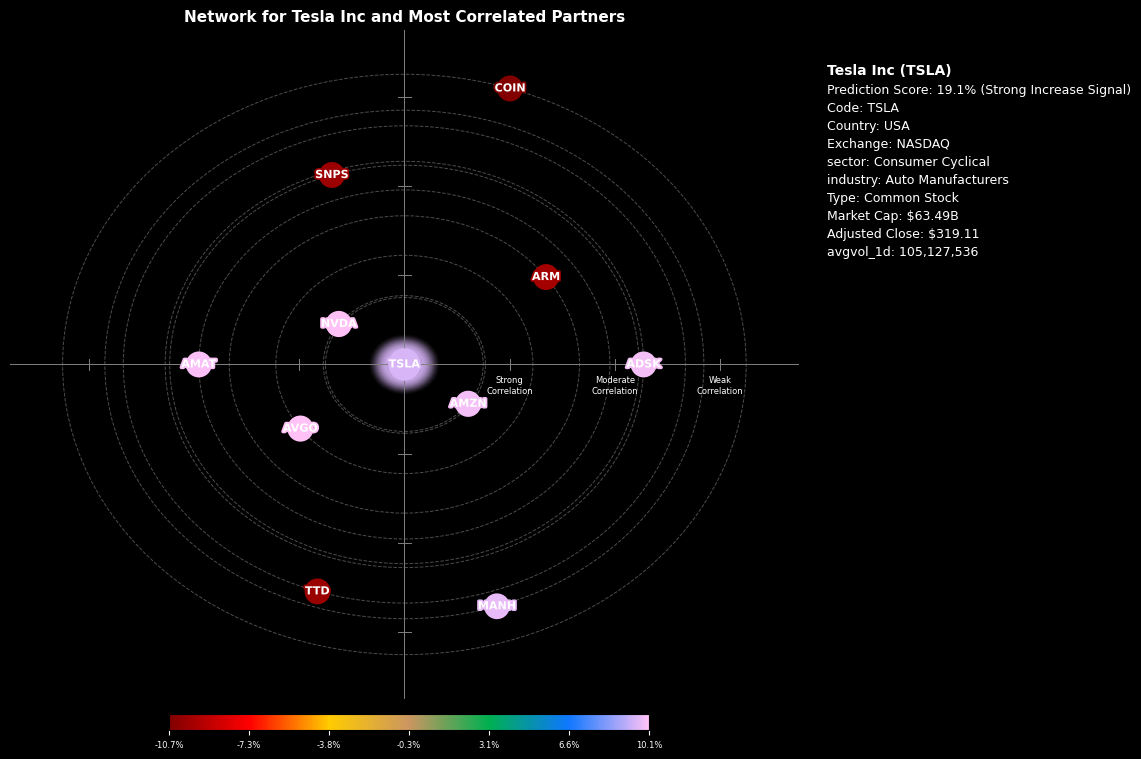

In [139]:
# --- MODIFIED: Network Diagram Plotting Function ---
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import random # Added random for shuffling node positions
import matplotlib.patheffects as path_effects # Import for text outline

def plot_ticker_network_visual(source_ticker, processed_data_df, prediction_score, screener_data_df):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    Includes a detailed information box for the source ticker.
    Takes the prediction_score (scalar) and the prediction_score_df.
    All data is sourced from the processed_data_df.
    """
    # Filter for connections related to the source ticker
    ticker_connections = processed_data_df[processed_data_df['source'] == source_ticker].copy()

    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    # Filter out any potential self-loops that might have slipped through, although they should be handled by process_and_score_stocks
    ticker_connections = ticker_connections[ticker_connections['source'] != ticker_connections['target']].copy()

    # Ensure the edge attributes list matches the columns available in ticker_connections
    # Corrected based on the expected columns from process_and_score_stocks
    edge_attributes = [
        'unified_correlation',
        'Orbital Radius',
        'Planet Radius',
        'normalized_prediction_score',
        'Daily Change',
        'Market Cap',
        'six_month_spearman_correlation',
        'three_month_spearman_correlation',
        'coefficient_of_determination'
    ]

    # Create the graph
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                edge_attributes)

    # Add the source ticker node explicitly if it's not already added as a target
    if source_ticker not in G.nodes():
        G.add_node(source_ticker)

    # Use subplots to have more control over the layout (graph on left, info on right)
    fig, (ax_main, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.patch.set_facecolor('black')
    ax_main.set_facecolor('black')
    ax_info.set_facecolor('black')

    # --- Reticle and Orbits on the main axis ---
    reticle_color = 'gray'
    ax_main.axhline(0, color=reticle_color, linestyle='-', linewidth=0.7)
    ax_main.axvline(0, color=reticle_color, linestyle='-', linewidth=0.7)

    radii = {'Strong': 0.4, 'Moderate': 0.8, 'Weak': 1.2}
    tick_length = 0.025

    for strength, r in radii.items():
        ax_main.plot([-tick_length, tick_length], [r, r], color=reticle_color, linewidth=0.7)
        ax_main.plot([-tick_length, tick_length], [-r, -r], color=reticle_color, linewidth=0.7)
        ax_main.plot([r, r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)
        ax_main.plot([-r, -r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)

    # Add labels for the reticle just below the tick marks on the positive x-axis
    label_offset_y = 0.05
    ax_main.text(radii['Strong'], -label_offset_y, 'Strong\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Moderate'], -label_offset_y, 'Moderate\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Weak'], -label_offset_y, 'Weak\nCorrelation', color='white', ha='center', va='top', fontsize=6)


    pos = {}
    pos[source_ticker] = (0, 0)

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)

        # Calculate min and max orbital radius from the filtered connections
        min_orbital_radius = actual_target_connections['Orbital Radius'].min()
        max_orbital_radius = actual_target_connections['Orbital Radius'].max()
        # Handle the case where all orbital radii are the same to avoid division by zero
        radius_range = max_orbital_radius - min_orbital_radius if max_orbital_radius != min_orbital_radius else 1.0


        for i, target_node_name in enumerate(list(actual_target_connections['target'])):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']

            # Use the already scaled orbital radius from processed_data_df
            scaled_orbital_radius = orbital_radius # This is now the value between 0 and 1

            min_distance = 0.3
            current_orbital_radius = scaled_orbital_radius + min_distance


            orbit_patch = plt.Circle((0, 0), current_orbital_radius, fill=False, linestyle='--', edgecolor=reticle_color, linewidth=0.7, alpha=0.6)
            ax_main.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    # --- Node Sizing and Coloring ---
    min_planet_size, max_planet_size = 0.05, 1.5
    epsilon = 1e-9

    # Get min/max market caps from the processed_data_df for consistent scaling within this plot
    # Include the source ticker's market cap for scaling if it's not already a target
    all_market_caps = processed_data_df['Market Cap'].tolist()
    source_info_row = processed_data_df[processed_data_df['source'] == source_ticker]
    source_market_cap_for_scaling = source_info_row['Market Cap'].iloc[0] if not source_info_row.empty else None

    if source_market_cap_for_scaling is not None:
         all_market_caps.append(source_market_cap_for_scaling)

    global_min_market_cap = min(all_market_caps) if all_market_caps else epsilon
    global_max_market_cap = max(all_market_caps) if all_market_caps else epsilon

    log_min_mc, log_max_mc = np.log(max(global_min_market_cap, epsilon)), np.log(max(global_max_market_cap, epsilon))


    # Calculate source node size using its market cap from processed_data_df
    source_market_cap = source_info_row['Market Cap'].iloc[0] if not source_info_row.empty else epsilon
    source_market_cap = max(source_market_cap, epsilon)
    log_source_mc = np.log(source_market_cap)
    normalized_source_mc = 0.0 if log_max_mc == log_min_mc else (log_source_mc - log_min_mc) / (log_max_mc - log_min_mc)
    source_planet_radius = min_planet_size + (normalized_source_mc * (max_planet_size - min_planet_size))
    source_node_size = 300 + (source_planet_radius * 500)

    node_sizes_dict = {node: 300 + (ticker_connections[ticker_connections['target'] == node]['Planet Radius'].values[0] * 500) if node != source_ticker else source_node_size for node in G.nodes()}
    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Use normalized_weight from processed_data_df for coloring ---
    colors = ['#820000', '#FF0000', '#FFCC00', '#CB9661', '#00B050', '#0E77FF', '#FFC1F6']
    cmap = mcolors.LinearSegmentedColormap.from_list('weight_cmap', colors)

    # Determine min/max weights for normalization to the colormap range (-1 to 1)
    all_weights = processed_data_df['normalized_prediction_score'].values
    min_weight, max_weight = np.min(all_weights), np.max(all_weights)
    norm_weights = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    node_colors_list = []
    # Ensure prediction_score is a scalar float
    prediction_score_scalar = float(prediction_score)
    for node in G.nodes():
        if node == source_ticker:
             # Color the source node based on the overall prediction score
            # Handle the case where prediction_score_scalar is 0 to avoid zero range in normalization
            if prediction_score_scalar == 0:
                norm_source = mcolors.Normalize(vmin=np.min(processed_data_df['prediction_score'].values), vmax=np.max(processed_data_df['prediction_score'].values))
            else:
                # Normalize based on the min/max prediction scores
                norm_source = mcolors.Normalize(vmin=np.min(processed_data_df['prediction_score'].values), vmax=np.max(processed_data_df['prediction_score'].values))

            source_node_color = cmap(norm_source(prediction_score_scalar))
            node_colors_list.append(source_node_color)
        else:
            # Color target nodes based on their signed normalized weight
            weight = processed_data_df[(processed_data_df['source'] == source_ticker) & (processed_data_df['target'] == node)]['normalized_prediction_score'].values
            if weight.size > 0:
                node_colors_list.append(cmap(norm_weights(weight[0])))
            else:
                # Default color if weight is not found (shouldn't happen with correct filtering)
                node_colors_list.append('gray')


    # --- Draw Aura and Nodes on the main axis ---
    aura_base_radius = np.sqrt(source_node_size / 300) * 0.05
    # Draw auras only for the source node
    for i in range(1, 15):
        aura = plt.Circle(pos[source_ticker], aura_base_radius * (1 + i * 0.07), color=source_node_color, alpha=0.3 * (1 - (i / 15)))
        ax_main.add_patch(aura)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=1.0, linewidths=0, ax=ax_main)

    # --- Draw Labels on the main axis ---
    node_color_map = dict(zip(G.nodes(), node_colors_list))
    for node in G.nodes():
        if node in pos:
            node_x, node_y = pos[node]
            node_color = node_color_map[node]
            txt = ax_main.text(node_x, node_y, str(node), color='white', fontweight='bold', fontsize=8, ha='center', va='center')
            txt.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground=node_color), path_effects.Normal()])

    # Fetch company name for the title from screener_data_df
    source_screener_info_for_title = screener_data_df[screener_data_df['code'] == source_ticker]
    company_name = source_screener_info_for_title['name'].iloc[0] if not source_screener_info_for_title.empty and 'name' in source_screener_info_for_title.columns else source_ticker
    ax_main.set_title(f'Network for {company_name} and Most Correlated Partners', color='white', fontsize=11, fontweight='bold')
    ax_main.axis('off')
    ax_main.set_xlim(-1.5, 1.5)
    ax_main.set_ylim(-1.5, 1.5)

    # --- Create Information Box on the right axis ---
    # Get source ticker info from screener_data_df
    source_screener_info = screener_data_df[screener_data_df['code'] == source_ticker].iloc[0] if not screener_data_df[screener_data_df['code'] == source_ticker].empty else None
    source_processed_info = processed_data_df[processed_data_df['source'] == source_ticker].iloc[0] if not processed_data_df[processed_data_df['source'] == source_ticker].empty else None


    if source_screener_info is None or source_processed_info is None:
         print(f"Warning: Source ticker {source_ticker} not found in necessary dataframes for info box.")
         info_text = "Information not available."
         company_name_info = source_ticker # Use ticker as name if not found
    else:
        # Determine prediction score text
        if prediction_score >= 1.0:
            score_meaning = "Strong Increase Signal"
        elif prediction_score > 0.8:
            score_meaning = "Increase Signal"
        elif prediction_score > 0.5:
            score_meaning = "Weak Increase Signal"
        elif prediction_score <= -1.0:
            score_meaning = "Strong Decrease Signal"
        elif prediction_score > 0.9:
            score_meaning = "Increase Signal"
        elif prediction_score < -0.5:
            score_meaning = "Weak Decrease Signal"
        else:
            score_meaning = "Neutral/Mixed Signals"

        # Format Market Cap for readability (using Market Cap from processed_data_df)
        market_cap = source_processed_info['Market Cap']
        if market_cap > 1_000_000_000_000:
            market_cap_str = f"${market_cap/1_000_000_000_000:.2f}T"
        elif market_cap > 1_000_000_000:
            market_cap_str = f"${market_cap/1_000_000_000:.2f}B"
        else:
            market_cap_str = f"${market_cap/1_000_000:.2f}M"

        # Assuming 'Daily Change' is in percentage in processed_data_df
        daily_change_percent = source_processed_info['Daily Change']

        # Format the information string, using screener_data_df for specific fields
        info_text = (
            # Divide prediction_score_scalar by 100 for display as percentage
            f"Prediction Score: {prediction_score_scalar / 100:.1%} ({score_meaning})\n"
            f"Code: {source_ticker}\n"
            # Get Country, Exchange, Sector, Industry, Type from screener_data_df
            f"Country: {source_screener_info.get('Country', 'N/A')}\n"
            f"Exchange: {source_screener_info.get('Exchange', 'N/A')}\n"
            f"sector: {source_screener_info.get('sector', 'N/A')}\n"
            f"industry: {source_screener_info.get('industry', 'N/A')}\n"
            f"Type: {source_screener_info.get('Type', 'N/A')}\n"
            f"Market Cap: {market_cap_str}\n"
            # Assuming adjusted_close and avgvol_1d are in screener_data_df
            f"Adjusted Close: ${source_screener_info.get('adjusted_close', 0):.2f}\n"
            f"avgvol_1d: {int(source_screener_info.get('avgvol_1d', 0)):,}"
        )
        # Corrected access to the 'name' attribute from the Series
        company_name_info = source_screener_info['name'] if 'name' in source_screener_info and not source_screener_info.empty else source_ticker


    # Add the text to the info axis, adjusting the y position to reduce the gap
    ax_info.text(0.05, 0.95, f"{company_name_info} ({source_ticker})", transform=ax_info.transAxes, fontsize=10, fontweight='bold', color='white', ha='left', va='top')
    ax_info.text(0.05, 0.92, info_text, transform=ax_info.transAxes, fontsize=9, color='white', ha='left', va='top', linespacing=1.5)
    ax_info.axis('off')

    # --- ADDED BACK: Add Colorbar Legend at the bottom of the main graph axis ---
    cbar_ax = fig.add_axes([0.145, 0.08, 0.4, 0.02]) # Adjusted position [left, bottom, width, height]
    # Use the same colormap and normalization as used for the target nod
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_weights)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    # Set the ticks and labels for the colorbar based on the range of normalized weights
    cbar.set_ticks(np.linspace(min_weight, max_weight, 7))
    # Generate labels that represent the range of weights, formatted as percentages
    labels = [f'{val:.1f}%' for val in np.linspace(min_weight, max_weight, 7)]
    cbar.set_ticklabels(labels)

    # Style the colorbar labels
    cbar.ax.tick_params(colors='white', labelsize=6)


    plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make room for colorbar
    plt.show()

## ---------- MODIFIED: Run App ---------------
min_nodes = 10
max_nodes = 50
threshold_percent = 0.9

# User input Ticker
source_ticker = 'TSLA'

# Process the data for the network diagram
processed_data_df, prediction_score = process_and_score_stocks(
    unified_correlation_df,
    six_month_spearman_lagged_correlations,
    three_month_spearman_lagged_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent,
    min_planet_size=0.05,
    max_planet_size=1.5
    )

# Pass the score and the prediction_score_df to the plotting function
plot_ticker_network_visual(source_ticker, processed_data_df, prediction_score, screener_data_df)

In [140]:
print(prediction_score)
print('---------')
processed_data_df

19.14488700381901
---------


,source,target,unified_correlation,coefficient_of_determination,six_month_spearman_correlation,three_month_spearman_correlation,Orbital Radius,Market Cap,Planet Radius,prediction_score,normalized_prediction_score,Daily Change
5,TSLA,ADSK,0.807729,0.652427,0.807729,0.874745,0.609894,63492452352,0.096100,20.104232,9.915109,0.606530
10,TSLA,AMAT,0.785752,0.617406,0.792609,0.785752,0.481770,140437143552,0.099132,20.174279,9.949655,1.279009
12,TSLA,AMZN,0.703114,0.494369,0.821189,0.703114,0.000000,2263416307712,0.109839,20.002419,9.864896,0.018762
16,TSLA,ARM,0.765887,0.586582,0.765887,0.781531,0.365958,146834620416,0.099303,-19.698115,-9.714818,-1.253740
18,TSLA,AVGO,0.735516,0.540984,0.735516,0.791176,0.188900,1204028309504,0.107404,20.460233,10.090683,1.249456
32,TSLA,COIN,0.874644,0.765003,0.888166,0.874644,1.000000,63849447424,0.096121,-21.774562,-10.738891,-3.841551
90,TSLA,MANH,0.847045,0.717485,0.932577,0.847045,0.839099,11495171072,0.089763,19.692615,9.712105,1.875033
111,TSLA,NVDA,0.704548,0.496388,0.731380,0.704548,0.008360,3536201973760,0.111561,20.357457,10.039996,1.519289
131,TSLA,SNPS,0.804733,0.647595,0.804733,0.812354,0.592427,77693763584,0.096868,-20.189812,-9.957315,-1.146326
142,TSLA,TTD,0.835029,0.697273,0.914047,0.835029,0.769048,35565441024,0.093909,-20.309883,-10.016533,-2.487218


##List of Top Predictions

In [58]:
# prompt: Generate a list of the top prediction scores. This should be a list of the ticker and the prediction score listed in order from greatest to least

import pandas as pd

sample_predictions_data = {
    'ticker': ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'SEIC', 'TSLA', 'NVDA', 'META'],
    'prediction_score': [0.5, 0.8, -0.2, 1.1, prediction_score, -0.7, 0.9, 0.1] # Include SEIC's actual score
}
prediction_scores_df = pd.DataFrame(sample_predictions_data)


sorted_predictions = prediction_scores_df.sort_values(by='prediction_score', ascending=False)

# Print the list of top predictions
print("Top Prediction Scores (Ticker: Score):")
for index, row in sorted_predictions.iterrows():
    print(f"{row['ticker']}: {row['prediction_score']:.1%}") # Format as percentage

Top Prediction Scores (Ticker: Score):
AMZN: 110.0%
NVDA: 90.0%
MSFT: 80.0%
AAPL: 50.0%
META: 10.0%
GOOG: -20.0%
TSLA: -70.0%
SEIC: -2488.7%


In [57]:
# prompt: Generate a list of the top prediction scores. This should be a list of the ticker and the prediction score. The prediction score should be larger than 95% and sort them by greatest to least

import pandas as pd
from tqdm import tqdm # Import tqdm for the progress bar
# Calculate prediction scores for all tickers in the processed data
all_tickers = processed_data['source'].unique().tolist()
prediction_scores = []

for ticker in tqdm(all_tickers, desc="Calculating Prediction Scores"):
    # calculate_prediction_score returns a tuple (score, prediction_score_df)
    score, _ = calculate_prediction_score(ticker, processed_data, screener_data_df)
    prediction_scores.append({'ticker': ticker, 'score': score})

# Create a DataFrame from the scores
prediction_df = pd.DataFrame(prediction_scores)

# Filter for scores greater than 95%
high_prediction_df = prediction_df[prediction_df['score'] > 0].copy()

# Sort the filtered DataFrame by score in descending order
sorted_high_predictions = high_prediction_df.sort_values(by='score', ascending=False)

# Convert the sorted DataFrame to a list of dictionaries
top_predictions_list = sorted_high_predictions.to_dict('records')

# Print the list of top predictions
print("\nTop Prediction Scores, sorted high to low:")
for item in top_predictions_list:
    print(f"  {item['ticker']}: {item['score']:.2f}")

Calculating Prediction Scores: 100%|██████████| 262/262 [00:01<00:00, 170.10it/s]


Top Prediction Scores, sorted high to low:
  ONC: 84.99
  EXC: 83.06
  EVRG: 82.76
  CELH: 82.15
  MDLZ: 80.22
  RGLD: 77.98
  PPC: 75.06
  XEL: 71.83
  ACGL: 66.77
  AZN: 65.22
  GILD: 64.73
  ORLY: 64.49
  AEP: 64.28
  WMG: 62.87
  PDD: 61.84
  KDP: 61.71
  ICLR: 61.59
  INTC: 60.32
  BMRN: 59.32
  AXON: 59.07
  CASY: 58.15
  BIDU: 46.85
  TER: 46.37
  SNY: 45.97
  AMGN: 45.25
  PEP: 43.56
  LINE: 42.92
  KHC: 42.15
  ERIC: 42.09
  EA: 41.59
  BKNG: 41.22
  SBAC: 40.89
  SMMT: 40.37
  ALNY: 40.14
  MSTR: 39.74
  KSPI: 39.69
  SFM: 39.69
  GLPI: 38.81
  BIIB: 38.29
  AUR: 37.58
  EXAS: 33.95
  VRTX: 33.29
  HTHT: 33.16
  ON: 29.28
  ZBRA: 27.79
  WWD: 27.73
  MRVL: 26.92
  CHKP: 25.85
  COO: 25.17
  AKAM: 24.87
  ERIE: 24.37
  LNT: 24.13
  MPWR: 23.55
  TMUS: 23.41
  NXPI: 23.19
  CPRT: 22.85
  CCEP: 22.83
  ROP: 22.48
  NDSN: 22.39
  HON: 22.31
  INTU: 21.92
  VTRS: 21.65
  EXPE: 21.45
  NBIS: 21.44
  CMCSA: 21.16
  GFS: 20.99
  NTRA: 20.89
  FAST: 20.62
  AMD: 20.44
  DPZ: 20.43
  

#Dash App

In [ ]:
# Install necessary libraries (run this cell first)
!pip install -q dash dash-bootstrap-components plotly

In [ ]:
from dash import Dash, html # Import the main Dash class to create our application.
import os # Import os to set environment variables for ngrok.
from pyngrok import ngrok # Import ngrok from pyngrok to create a public tunnel.
from google.colab import userdata # Import userdata to access Colab secrets

# --- Configure Ngrok for public access ---
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN

# Define the port your Dash app will run on.
DASH_PORT = 8050

# Create a public ngrok tunnel to the specified port. This will generate a
# public URL that you can access from anywhere, including your iPad, bypassing Colab's iframe restrictions.
print("Establishing Ngrok tunnel...")
public_url = ngrok.connect(DASH_PORT)
print(f"Your Dash app will be accessible at: {public_url}")

# --- Initialize the Dash application ---
app = Dash(__name__)

# --- Define the app layout ---
app.layout = html.Div([
    html.H1("Welcome to the Finacial Observatory!", style={'textAlign': 'center', 'color': 'blue'}),
    html.P("I love you, Nix!", style={'textAlign': 'center', 'color': 'green'})
])

# --- Run the Dash server ---
print(f"Starting Dash server on port {DASH_PORT}...")
app.run(debug=True, port=DASH_PORT)

# Important Note:
# Keep this Colab notebook cell running and active for your app to remain live.
# If the Colab runtime disconnects or the cell execution stops, your app will go offline.

Establishing Ngrok tunnel...
Your Dash app will be accessible at: NgrokTunnel: "https://0456-34-83-174-46.ngrok-free.app" -> "http://localhost:8050"
Starting Dash server on port 8050...


<IPython.core.display.Javascript object>

In [ ]:
from pyngrok import ngrok

# Kills all ngrok processes that pyngrok started
print("Attempting to kill all active ngrok tunnels...")
ngrok.kill()
print("All ngrok tunnels should now be terminated.")

Attempting to kill all active ngrok tunnels...
All ngrok tunnels should now be terminated.


In [ ]:
# --- Import necessary libraries ---
from dash import Dash, html, dcc, Input, Output # We need dcc for interactive components and Input/Output for callbacks
import os
from pyngrok import ngrok
from google.colab import userdata

# --- Configure Ngrok for public access ---
# This part remains the same to create a public URL for your app
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN
except userdata.SecretNotFoundError:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")
    # You might want to handle this case, e.g., by exiting or using a default token if applicable
    exit()


# Define the port your Dash app will run on.
DASH_PORT = 8051

# Create a public ngrok tunnel to the specified port.
print("Establishing Ngrok tunnel...")
public_url = ngrok.connect(DASH_PORT)
print(f"🚀 Your Dash app will be accessible at: {public_url}")

# --- Initialize the Dash application ---
app = Dash(__name__)

# --- Define the app layout ---
# The layout is what the user sees. We've added an input box and a div for the output.
app.layout = html.Div([
    html.H1("Simple Interactive App", style={'textAlign': 'center', 'color': '#4A90E2'}),

    html.P("Type something in the box below:", style={'textAlign': 'center'}),

    # dcc.Input is an interactive component that allows user text input.
    dcc.Input(
        id='user-input-box',      # A unique ID to identify this component in callbacks
        type='text',               # The type of input (text, number, password, etc.)
        placeholder='Enter your message here...', # Placeholder text
        style={'width': '50%', 'padding': '10px', 'margin': 'auto', 'display': 'block'}
    ),

    # This html.Div will be used to display the output from our callback.
    # It starts empty.
    html.Div(
        id='app-output-div',
        style={'textAlign': 'center', 'marginTop': '20px', 'fontSize': '24px', 'color': '#50E3C2'}
    )
])

# --- Define the Callback ---
# This is the core of the app's interactivity.
# It connects the input component to the output component.
@app.callback(
    Output('app-output-div', 'children'), # The component property we want to update (the content of the div)
    Input('user-input-box', 'value')      # The component property that triggers the callback (the value of the input box)
)
def update_output_div(input_value):
    """
    This function is called automatically by Dash whenever the 'value' of the 'user-input-box' changes.
    The new value is passed as the 'input_value' argument.
    The function's return value is used to update the 'children' of the 'app-output-div'.
    """
    if input_value is None or input_value == '':
        return "Type something to get a response!"
    else:
        # The f-string creates a new string with the user's input.
        return f'The app says: "{input_value}"'

# --- Run the Dash server ---
print(f"Starting Dash server on port {DASH_PORT}...")
# The host='0.0.0.0' is important for running in environments like Colab
app.run(debug=True, port=DASH_PORT)

# Important Note:
# Keep this Colab notebook cell running and active for your app to remain live.
# If the Colab runtime disconnects or the cell execution stops, your app will go offline.


Establishing Ngrok tunnel...
🚀 Your Dash app will be accessible at: NgrokTunnel: "https://bf60-34-83-174-46.ngrok-free.app" -> "http://localhost:8051"
Starting Dash server on port 8051...


<IPython.core.display.Javascript object>

In [ ]:
# Display descriptive statistics of the calculated scores
print("Descriptive statistics of prediction scores:")
display(prediction_df['score'].describe())

# Display the first few rows of the prediction_df to see sample scores
print("\nSample of calculated prediction scores:")
display(prediction_df.head())

# Check the maximum score to see if it's close to the threshold
max_score = prediction_df['score'].max()
print(f"\nMaximum prediction score: {max_score:.2f}")

# Check how many scores are above 95
count_above_95 = (prediction_df['score'] > 95).sum()
print(f"\nNumber of tickers with score > 95: {count_above_95}")

Descriptive statistics of prediction scores:


,score
count,261.000000
mean,-41.240832
std,29.504366
min,-100.000000
25%,-62.365173
50%,-40.785424
75%,-23.796721
max,44.134355



Sample of calculated prediction scores:


,ticker,score
0,AAPL,-2.079788
1,ABNB,-73.324077
2,ACGL,1.388236
3,ADBE,-70.945344
4,ADI,-83.863688



Maximum prediction score: 44.13

Number of tickers with score > 95: 0


In [111]:
# Pass the score and the processed_data_df to the plotting function
plot_ticker_network_visual(source_ticker, processed_data_df, prediction_score)

NetworkXError: Invalid edge_attr argument: ['unified_correlation', 'Orbital Radius', 'Planet Radius', 'normalized_prediction_score', 'Daily Change', 'Market Cap', 'six_month_spearman_correlation', 'three_month_spearman_correlation', 'coefficient_of_determination']